In [1]:
from datahandler import *
from playground import *
from gui import *
from torchutils import *
from models import *
from torch.utils.data import WeightedRandomSampler
import matplotlib.pyplot as plt
from gui import visualize_model_outputs
from backtest import *

In [2]:
data = pd.read_csv("BTCUSDT_15m.csv")
data.drop(["Unnamed: 0", "Close Unix"], axis=1, inplace=True)

handler = NewDataHandler(dataset=data)

seq_length = 15

crossover_horizon = 3

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = torch.load(
f'./models/crossover_{seq_length}_to_{crossover_horizon}.pt').to(device)

ma1, ma2, ma_mode = 5, 10, 'normal'
ma_modes = {'exponential': 'EMA', 'normal': 'MA'}
ma_name = ma_modes[ma_mode]
k1, k2 = 5, 10

handler.data = ma_crossover_labelling(handler.data, ma1, ma2, crossover_horizon, ma_mode)

handler.data = add_kendall_tau(handler.data, k1)
handler.data = add_kendall_tau(handler.data, k2)
handler.data = add_ichimoku(handler.data)
ichimoku_cols = ['ABOVE_ICHIMOKU_9', 'ABOVE_ICHIMOKU_26', 'Close_ICHIMOKU_9_PERC_DIFF', 'Close_ICHIMOKU_26_PERC_DIFF']

handler.add_indicators([Indicators.RSI, Indicators.MACD,
                    Indicators.ADX])

handler.create_var_indicator([Indicators.RSI, Indicators.MACD, Indicators.ADX, Indicators.LOG_RET])

# display(handler.data[handler.data.isnull().any(axis=1)]) # Displaying all the rows that contain missing values to see if they are spread across the dataframe

handler.data.replace([np.inf, -np.inf], 0, inplace=True)

# handler.standardize_data()

handler.data.dropna(axis=0, inplace=True)

handler.create_predict_data()

# handler.data.drop('NTrades', axis=1, inplace=True)

predict_data = handler.predict_data
predict_data['Target'] = handler.data['Label']
predict_data[[f'Kendall_{k1}', f'Kendall_{k2}']] = handler.data[[f'Kendall_{k1}', f'Kendall_{k2}']]
predict_data[f'{ma_name}{ma1} Var'], predict_data[f'{ma_name}{ma2} Var'] = handler.data[f'{ma_name}{ma1} Var'], handler.data[f'{ma_name}{ma2} Var']
predict_data[f'Close_{ma_name}{ma1}_PERC_DIFF'], predict_data[f'Close_{ma_name}{ma2}_PERC_DIFF'] = handler.data[f'Close_{ma_name}{ma1}_PERC_DIFF'], handler.data[f'Close_{ma_name}{ma2}_PERC_DIFF']
predict_data[f'{ma_name}{ma1} UP'], predict_data[f'{ma_name}{ma2} UP'] = (handler.data[f'{ma_name}{ma1}'] > handler.data[f'{ma_name}{ma2}']) * 1, (handler.data[f'{ma_name}{ma1}'] < handler.data[f'{ma_name}{ma2}']) * 1
predict_data[ichimoku_cols] = handler.data[ichimoku_cols]
predict_data.reset_index(drop=True, inplace=True)
handler.data.reset_index(drop=True, inplace=True)

C:\Users\Alexis\AppData\Local\Temp\ipykernel_12964\1327530373.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_data['Target'] = handler.data['Label']
C:\Users\Alexis\AppData\Local\Temp\ipykernel_12964\1327530373.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_data[[f'Kendall_{k1}', f'Kendall_{k2}']] = handler.data[[f'Kendall_{k1}', f'Kendall_{k2}']]
C:\Users\Alexis\AppData\Local\Temp\ipykernel_12964\1327530373.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

In [3]:
handler.data = handler.data.drop(range(0, round(0.7 * handler.data.shape[0]))).reset_index(drop=True)
handler.data

,Unix,Open,High,Low,Close,Volume,Quote Asset Volume,NTrades,MA5,MA10,MA5 Var,MA10 Var,Close_MA5_PERC_DIFF,Close_MA10_PERC_DIFF,Label,Kendall_5,Kendall_10,ICHIMOKU_9,ICHIMOKU_26,ABOVE_ICHIMOKU_9,ABOVE_ICHIMOKU_26,Close_ICHIMOKU_9_PERC_DIFF,Close_ICHIMOKU_26_PERC_DIFF,RSI,RSI_30-,RSI_BTW,RSI_70+,MACD,MACD_H,ADX14,+DM,-DM,RSI Var,MACD Var,MACD_H Var,ADX14 Var,-DM Var,+DM Var,LOG_RET
0,1625313600000,34608.04,34816.50,34541.53,34641.53,964.628252,3.347594e+07,18360,34575.250,34603.890,0.000221,0.000149,-0.001913,-0.001087,1,0.4,-0.288889,33573.4250,33478.125,1,1,-0.030833,-0.033584,66.679589,0,1,0,188.574565,-29.405246,38.292847,33.693735,13.315275,0.018808,-0.030763,-0.044391,0.010263,-0.120013,0.201338,0.000967
1,1625314500000,34641.54,34641.54,34555.86,34618.39,334.821171,1.158201e+07,8939,34578.646,34602.365,0.000098,-0.000044,-0.001148,-0.000463,1,0.6,-0.111111,33587.0150,33478.125,1,1,-0.029793,-0.032938,64.957587,0,1,0,179.890272,-30.471631,38.654080,32.389339,12.799797,-0.025825,-0.046052,0.036265,0.009433,-0.038713,-0.038713,-0.000668
2,1625315400000,34618.40,34620.00,34543.47,34567.73,254.686592,8.807571e+06,7727,34583.414,34597.876,0.000138,-0.000130,0.000454,0.000872,1,0.2,-0.200000,33618.8950,33478.125,1,1,-0.027449,-0.031521,61.229485,0,1,0,166.995053,-34.693480,38.854703,31.226498,12.921503,-0.057393,-0.071684,0.138550,0.005190,0.009508,-0.035902,-0.001464
3,1625316300000,34567.74,34596.62,34482.27,34543.97,347.967733,1.201754e+07,8506,34595.932,34590.407,0.000362,-0.000216,0.001504,0.001344,-1,-0.6,-0.200000,33630.4325,33478.125,1,1,-0.026446,-0.030855,59.504545,0,1,0,153.093499,-38.876027,38.379650,29.521047,15.138804,-0.028172,-0.083245,0.120557,-0.012226,0.171598,-0.054616,-0.000688
4,1625317200000,34543.97,34586.78,34470.00,34537.96,423.189704,1.460716e+07,7832,34581.916,34574.769,-0.000405,-0.000452,0.001273,0.001066,0,-1.0,-0.155556,33613.3200,33478.125,1,1,-0.026772,-0.030686,59.051381,0,1,0,139.977883,-41.593314,37.806942,27.848295,14.876348,-0.007616,-0.085671,0.069896,-0.014922,-0.017337,-0.056663,-0.000174
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58001,1677537900000,23397.31,23557.79,23390.54,23482.13,3276.986710,7.697566e+07,118924,23405.900,23366.460,0.000866,0.000960,-0.003246,-0.004926,0,0.6,0.866667,23546.6300,23546.630,0,0,0.002747,0.002747,61.932773,0,1,0,0.601898,25.433536,24.975911,27.116201,18.390167,0.147908,-1.057597,0.226309,-0.017551,-0.127108,0.434192,0.003619
58002,1677538800000,23481.28,23508.27,23448.20,23467.31,2209.161100,5.187482e+07,84221,23423.086,23388.653,0.000734,0.000950,-0.001884,-0.003352,0,0.6,0.822222,23528.6600,23528.660,0,0,0.002614,0.002614,59.976988,0,1,0,8.071806,26.322756,24.561590,25.845527,17.528397,-0.031579,12.410594,0.034962,-0.016589,-0.046860,-0.046860,-0.000631
58003,1677539700000,23467.89,23525.88,23466.17,23490.51,1624.076700,3.816044e+07,74878,23443.360,23405.567,0.000866,0.000723,-0.002007,-0.003616,0,0.8,0.822222,23528.6600,23528.660,0,0,0.001624,0.001624,62.000045,0,1,0,15.683025,27.147179,24.367283,26.019732,16.691128,0.033731,0.942939,0.031320,-0.007911,-0.047766,0.006740,0.000988
58004,1677540600000,23491.18,23555.24,23480.79,23534.67,1677.606430,3.944878e+07,81570,23474.386,23425.349,0.001323,0.000845,-0.002561,-0.004645,0,0.8,0.822222,23528.6600,23528.660,1,1,-0.000255,-0.000255,65.567754,0,1,0,24.990241,29.163517,24.498989,26.828370,15.685094,0.057544,0.593458,0.074274,0.005405,-0.060274,0.031078,0.001878


In [4]:
predict_data = predict_data.drop(range(0, round(0.7 * predict_data.shape[0]))).reset_index(drop=True)
predict_data

,Unix,RSI Var,MACD Var,MACD_H Var,ADX14 Var,-DM Var,+DM Var,RSI_30-,RSI_BTW,RSI_70+,LOG_RET,Target,Kendall_5,Kendall_10,MA5 Var,MA10 Var,Close_MA5_PERC_DIFF,Close_MA10_PERC_DIFF,MA5 UP,MA10 UP,ABOVE_ICHIMOKU_9,ABOVE_ICHIMOKU_26,Close_ICHIMOKU_9_PERC_DIFF,Close_ICHIMOKU_26_PERC_DIFF
0,1625313600000,0.018808,-0.030763,-0.044391,0.010263,-0.120013,0.201338,0,1,0,0.000967,1,0.4,-0.288889,0.000221,0.000149,-0.001913,-0.001087,0,1,1,1,-0.030833,-0.033584
1,1625314500000,-0.025825,-0.046052,0.036265,0.009433,-0.038713,-0.038713,0,1,0,-0.000668,1,0.6,-0.111111,0.000098,-0.000044,-0.001148,-0.000463,0,1,1,1,-0.029793,-0.032938
2,1625315400000,-0.057393,-0.071684,0.138550,0.005190,0.009508,-0.035902,0,1,0,-0.001464,1,0.2,-0.200000,0.000138,-0.000130,0.000454,0.000872,0,1,1,1,-0.027449,-0.031521
3,1625316300000,-0.028172,-0.083245,0.120557,-0.012226,0.171598,-0.054616,0,1,0,-0.000688,-1,-0.6,-0.200000,0.000362,-0.000216,0.001504,0.001344,1,0,1,1,-0.026446,-0.030855
4,1625317200000,-0.007616,-0.085671,0.069896,-0.014922,-0.017337,-0.056663,0,1,0,-0.000174,0,-1.0,-0.155556,-0.000405,-0.000452,0.001273,0.001066,1,0,1,1,-0.026772,-0.030686
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58001,1677537900000,0.147908,-1.057597,0.226309,-0.017551,-0.127108,0.434192,0,1,0,0.003619,0,0.6,0.866667,0.000866,0.000960,-0.003246,-0.004926,1,0,0,0,0.002747,0.002747
58002,1677538800000,-0.031579,12.410594,0.034962,-0.016589,-0.046860,-0.046860,0,1,0,-0.000631,0,0.6,0.822222,0.000734,0.000950,-0.001884,-0.003352,1,0,0,0,0.002614,0.002614
58003,1677539700000,0.033731,0.942939,0.031320,-0.007911,-0.047766,0.006740,0,1,0,0.000988,0,0.8,0.822222,0.000866,0.000723,-0.002007,-0.003616,1,0,0,0,0.001624,0.001624
58004,1677540600000,0.057544,0.593458,0.074274,0.005405,-0.060274,0.031078,0,1,0,0.001878,0,0.8,0.822222,0.001323,0.000845,-0.002561,-0.004645,1,0,1,1,-0.000255,-0.000255


In [5]:
visualize_model_outputs(handler.data, predict_data, model, seq_length, device, False)

99.974140606144196756
 -2    6431
 2    3371
-1     578
 1     573
Name: count, dtype: int64 10953


99.97586456573458456


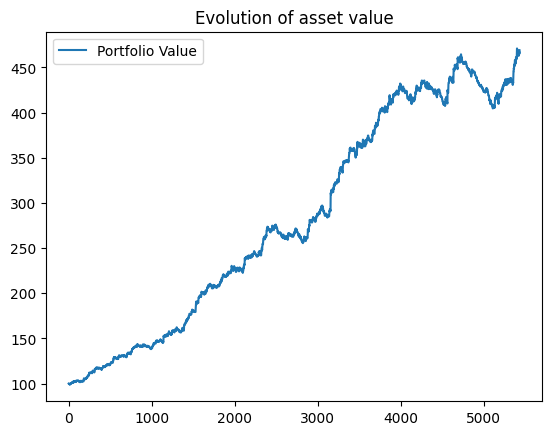

In [6]:
backtest_crossover(handler.data, predict_data, model, seq_length, device)